In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The same steps that were applied to the training set are applied to the validation set.

In [2]:
!pip install demoji

     |████████████████████████████████| 42 kB 940 kB/s 


In [3]:
import demoji

In [4]:
import pandas as pd
import numpy as np
import pathlib
import re


import gensim
import gensim.corpora as corp
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from collections import Counter
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
stopwords_dict = Counter(stop_words)

In [6]:
import spacy
spacy.prefer_gpu()

False

In [7]:
from wordcloud import wordcloud
import matplotlib.pyplot as plt

In [8]:
path = pathlib.Path.cwd()
file_loc = path / 'gdrive/My Drive'
file_loc

PosixPath('/content/gdrive/My Drive')

In [50]:
df = pd.read_csv(file_loc/'2020_12_2021_02_validation_bernoulli.csv')

In [51]:
df.head()

,id,dt,thetype,body
0,laguph,2021-02-01 23:59:37,post,amazing news to see the big guns siding with u...
1,lagu8d,2021-02-01 23:59:01,post,Why is GME going down!? listen weak hearted pe...
2,lagu6e,2021-02-01 23:58:57,post,SHORT SELLER ....ANDREW LEFT ATTACKING COVID C...
3,lagtxo,2021-02-01 23:58:38,post,Is it possible to ladder up? [removed]
4,lagtd0,2021-02-01 23:57:59,post,What’s happening with GME ? [removed]


It is immediately apparent that there are mentions of GME and shorts.


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318376 entries, 0 to 318375
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       318376 non-null  object
 1   dt       318376 non-null  object
 2   thetype  318376 non-null  object
 3   body     318376 non-null  object
dtypes: object(4)
memory usage: 9.7+ MB


In [53]:
df.thetype = df.thetype.astype('category')

In [54]:
df.thetype.value_counts()

comment    288693
post        29683
Name: thetype, dtype: int64

In [55]:
df.dt = pd.to_datetime(df.dt)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318376 entries, 0 to 318375
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   id       318376 non-null  object        
 1   dt       318376 non-null  datetime64[ns]
 2   thetype  318376 non-null  category      
 3   body     318376 non-null  object        
dtypes: category(1), datetime64[ns](1), object(2)
memory usage: 7.6+ MB


In [57]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('[removed]', 25895), ('[deleted]', 9274), ('Yes', 542), ('Ban', 389), ('This is the way', 378), ('Upload meme content directly to Reddit please.*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*', 339), ('No', 236), ('GME', 196), ('Nobody tell him*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*', 194), ('Same', 170)]
[('BB', 160), ('Lol', 149), ('F', 127), ('yes', 123), ('This is the way.', 119), ('🚀🚀🚀', 108), ('Sir, this is the unemployment line.*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*', 105), ('Why?', 79), ('Hold', 79), ('🤡', 77)]
[('This', 75), ('Yes.', 74), ('Lmao'

At the first glance, some of the common patterns that stick out are specific mentions to stock indexes, copius amounts of emoji's, as well as more links, removed and deleted comments as well as some bot interventions and posts against RobinHood, as well as Trump's whitehouse bio.

I shall continue with the same preprocessing steps as before and may end up removing the converted emoji text later on. This will depend on how they affect the overall frequency of certain words. If there are increased frequencies then they will be removed from both the training and validation sets.

In [58]:
df.isna().any()

id         False
dt         False
thetype    False
body       False
dtype: bool

There are no instances of missing text in the validation set.

In [59]:
df.dropna(inplace=True)

In [60]:
df.shape

(318376, 4)

In [61]:
def replace_emoji(sentence):
  found_emoji = demoji.findall(sentence)
  if len(found_emoji.keys()) !=0:
   sentence = demoji.replace_with_desc(sentence, sep=' ')
  return sentence

def replace_bot_text(sentence):
  if 'i am a bot' in sentence.lower():
    sentence = 'bot response'
  return sentence

def remove_link(sentence):
  sentence = re.sub('\S*\.com*\S*\s?', '', sentence)
  sentence = re.sub('\S*\.gov*\S*\s?', '', sentence)
  return sentence

def replace_bot_text(sentence):
  if 'i am a bot' in sentence.lower():
    sentence = 'bot response'
  elif 'wsbvotebot' in sentence.lower():
    sentence = 'bot response'
  return sentence

def conjugate_operations(sentence):
  sentence = replace_bot_text(sentence)
  sentence = remove_link(sentence)
  sentence = replace_emoji(sentence)
  return sentence
 

In [62]:
df['body'] = df['body'].apply(conjugate_operations)

In [65]:
df.head()

,id,dt,thetype,body
0,laguph,2021-02-01 23:59:37,post,amazing news to see the big guns siding with u...
1,lagu8d,2021-02-01 23:59:01,post,Why is GME going down!? listen weak hearted pe...
2,lagu6e,2021-02-01 23:58:57,post,SHORT SELLER ....ANDREW LEFT ATTACKING COVID C...
3,lagtxo,2021-02-01 23:58:38,post,Is it possible to ladder up? [removed]
4,lagtd0,2021-02-01 23:57:59,post,What’s happening with GME ? [removed]


In [64]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('[removed]', 25898), ('[deleted]', 9274), ('bot response', 2077), ('', 665), ('Yes', 542), ('Ban', 389), ('This is the way', 378), ('No', 236), ('GME', 196), ('Same', 170)]
[('BB', 161), ('Lol', 149), ('F', 127), ('yes', 123), ('This is the way.', 119), (' rocket  rocket  rocket ', 108), ('Why?', 79), ('Hold', 79), (' clown face ', 77), ('This', 75)]
[('Yes.', 74), ('Lmao', 74), ('lol', 67), ('Nice', 64), ('ban', 63), ('no', 63), ('AMC [removed]', 59), ('Nope', 59), ('Why', 59), ('BAN', 58)]
[(' rocket ', 57), ('Gme', 55), ('Yep', 53), ('Source?', 53), ('Yup', 53), ('Thanks', 52), (' face with tears of joy ', 52), ('Nah', 52), ('GUH', 51), ('this is the way', 49)]
[('Both', 49), (' rocket  rocket  rocket  rocket ', 47), (' rocket  rocket  rocket  rocket  rocket ', 43), ('?', 43), ('Shares', 43), ('1000', 43), ('Fuck off', 42), ('ICLN', 42), ('same', 41), ('RIP', 41)]
[('PLTR', 41), ('GME [removed]', 40), (' rainbow  bear ', 39), ('LOL', 39), ('HOLD', 39), ('Link?', 38), ('Thank you',

There are more instances of removed and deleted posts than intervention posts from bots.

In [66]:
df[df.thetype == 'post'].id.duplicated().value_counts()

False    29683
Name: id, dtype: int64

A check to make sure that there are no duplicate posts, i.e. during the random sampling of the data from the database no id was selected more than once.

In [67]:
#checking to see where the text is only deleted or removed
rd_res = df[(df['body'] == '[deleted]') | (df['body'] == '[removed]')]

In [68]:
rd_res.thetype.value_counts()

comment    35169
post           3
Name: thetype, dtype: int64

In [26]:
rd_res[rd_res['thetype'] == 'post']

,id,dt,thetype,body
13523,l9f8s9,2021-01-31 17:06:07,post,[removed]
17147,l99cpq,2021-01-31 10:54:59,post,[removed]
59129,l78teg,2021-01-28 22:05:26,post,[removed]


In the validation set there are only 3 posts that were removed, whereas there are 35k comments that have been removed or deleted.

Again these will all be removed since they don't offer any insight into the community discourse.

In [69]:
df = df[~df.index.isin(rd_res.index)].copy()

In [70]:
def remove_deleted_text(sentence):
  return re.sub(r'\s\[.*?\]', '', sentence)
  

In [71]:
df.body = df.body.apply(lambda x: remove_deleted_text(x))

In [72]:
top200 = Counter(df.body).most_common(200)
for i in range(20):
  print(top200[i*10 : (i+1)*10])

[('bot response', 2077), ('', 665), ('Yes', 544), ('Ban', 389), ('This is the way', 379), ('GME', 237), ('No', 236), ('Same', 170), ('BB', 169), ('Lol', 151)]
[('F', 127), ('yes', 123), ('This is the way.', 119), (' rocket  rocket  rocket ', 110), ('Hold', 82), ('AMC', 79), ('Why?', 79), (' clown face ', 77), ('This', 75), ('Yes.', 74)]
[('Lmao', 74), ('lol', 67), ('Nice', 66), ('Gme', 63), ('ban', 63), ('no', 63), (' rocket ', 60), ('Nope', 59), ('Why', 59), ('BAN', 58)]
[('Yep', 53), ('Source?', 53), ('Thanks', 53), ('Yup', 53), ('GUH', 52), (' face with tears of joy ', 52), ('Nah', 52), ('HOLD', 49), (' rocket  rocket  rocket  rocket ', 49), ('this is the way', 49)]
[('Both', 49), ('PLTR', 45), (' rocket  rocket  rocket  rocket  rocket ', 44), ('?', 43), ('Shares', 43), ('1000', 43), ('Fuck off', 42), ('ICLN', 42), ('NOK', 41), ('same', 41)]
[('RIP', 41), ('LOL', 40), ('Thank you', 39), (' rainbow  bear ', 39), ('Link?', 38), ('Dogecoin', 38), ('Bb', 38), ('Priced in', 38), ('Facts'

In [73]:
char_instances = df[(df.body == '') |(df.body == '.') | (df.body == ' ') | (df.body == '.') | (df.body == '?') | (df.body == '...') | (df.body == ':)') | (df.body == ':(')]

In [74]:
char_instances.thetype.value_counts()

comment    751
post        10
Name: thetype, dtype: int64

In [75]:
char_instances[char_instances.thetype == 'post']

,id,dt,thetype,body
46,lagj1h,2021-02-01 23:45:35,post,
2110,la9kd1,2021-02-01 19:02:44,post,
6054,l9si5w,2021-02-01 03:27:11,post,
18681,l93fur,2021-01-31 04:30:39,post,
28612,l8l1o6,2021-01-30 13:50:26,post,
34568,l80mse,2021-01-29 19:50:18,post,
41246,l7tzjx,2021-01-29 15:35:22,post,
41366,l7tjbt,2021-01-29 15:15:31,post,
56119,l7bblm,2021-01-28 23:44:09,post,
56365,l7aq9h,2021-01-28 23:20:29,post,:)


There are far fewer instances of comments and posts that are either punctuation, empty strings, or extra spaces. All 761 will be removed.

In [76]:
df = df[~df.index.isin(char_instances.index)].copy()

In [35]:
bot_responses = df[df.body =='bot response']
bot_responses

,id,dt,thetype,body
12,lagr39,2021-02-01 23:55:36,comment,bot response
21,lagpk8,2021-02-01 23:53:42,comment,bot response
52,laggv3,2021-02-01 23:42:57,comment,bot response
79,lagc02,2021-02-01 23:36:51,comment,bot response
86,lagaip,2021-02-01 23:35:16,comment,bot response
...,...,...,...,...
318345,k4xm36,2020-12-02 22:39:55,comment,bot response
318346,k4xm36,2020-12-02 22:59:57,comment,bot response
318347,k4xm36,2020-12-03 00:03:27,comment,bot response
318352,k4wst9,2020-12-02 00:22:43,comment,bot response


In [36]:
bot_responses.thetype.value_counts()

comment    2071
post          6
Name: thetype, dtype: int64

In [37]:
df = df[~df.index.isin(bot_responses.index)].copy()

At this point we are finally at a place where we can start lemmatizing the texts, the bot intervention comments have been removed, as well as all of the instances of removed or deleted posts, and all of the empty strings, blank spaces, and punctuation comments and posts.

The dataset is finally ready for the simple preprocessing to remove remaining punctuation as well as casting all of the text to lower case. From there the stopwords will be removed, then making bigrams and trigrams, and finally the text will be fed into a spacy pipeline and lemmatized where only nouns, verbs adverbs and adjectives will be kept based the pos tag of the original word.

In [77]:
df['body'] = df['body'].apply(lambda x: simple_preprocess(str(x),deacc=True))

In [78]:
content = df.body.values.tolist()

In [79]:
bigram = gensim.models.Phrases(content, min_count=5, threshold=100) # could potentially grid search this.
trigram = gensim.models.Phrases(bigram[content], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mode = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [80]:
nlp = spacy.load('en', disable =['ner','parser'])


In [81]:
def remove_sw(sentences):
    new_sentences = [[word for word in sentence if word not in stopwords_dict] for sentence in sentences]
    return new_sentences

def make_bigrams(sentences):
    bigrams = [bigram_mod[sentence] for sentence in sentences]
    return bigrams
def make_trigrams(sentences):
  trigrams = [trigram_mode[sentence] for sentence in sentences]
  return trigrams


def do_lemmatization(doc, pos_tags =['NOUN','ADJ','VERB','ADV']):
    """will do lemmatization using the pipe on all of the texts as once"""
    lemmatized_list = [token.lemma_ for token in doc if token.pos_ in pos_tags]
    return lemmatized_list

def preproc_pipe(texts):
  outputs = []
  for doc in nlp.pipe(texts, disable=['parser','ner'], batch_size=1000):
    outputs.append(do_lemmatization(doc))
  return outputs




In [82]:
content_no_sw = remove_sw(content)

In [83]:
content_bigrams = make_bigrams(content_no_sw)
content_trigrams = make_trigrams(content_bigrams)

In [84]:
del(content)
del(content_no_sw)
del(content_bigrams)

In [85]:
df['tri_grams'] = content_trigrams
del(content_trigrams)
df['tri_grams'] = df.tri_grams.apply(lambda x: ' '.join(x))

In [86]:
df['preprocessed'] = preproc_pipe(df['tri_grams'])

In [87]:
df.to_csv(file_loc/'preprocessed_validation.csv')

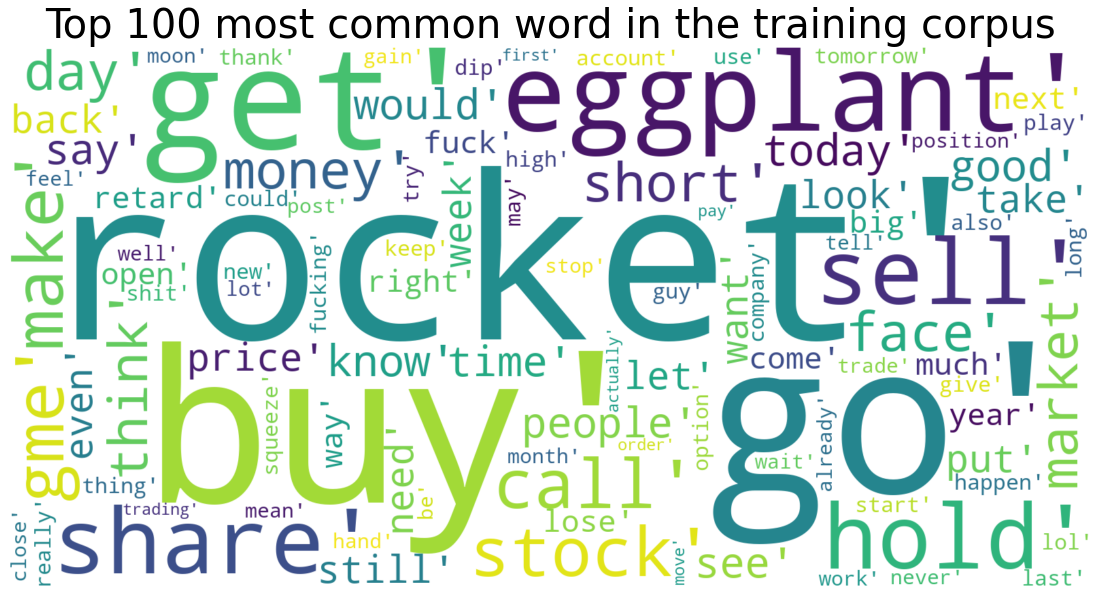

In [88]:
wrdlst = []
for item in df.preprocessed.values:
  wrdlst.extend(item)


most_common = nltk.probability.FreqDist(wrdlst).most_common(100)
wrdcld = wordcloud.WordCloud(width=1600, height= 800, background_color='white')\
.generate(str(most_common))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wrdcld, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common word in the training corpus', fontsize=40)

plt.show()


Rocket, and eggplant (text descriptions of emojis) have worked there way into the top frequency of words. However, others amongst these that are apparent are: stock, gme, put, call, short, buy, sell, hold, position, squeeze.

A good number of things expected from the period leading up to and immediately following the shortsqueeze on GME stocks